In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time
import matplotlib.pyplot as plt
import random
from scipy import stats
import numpy as np
import string

In [3]:
#@title
path = "/content/drive/My Drive/"
fileName = "covid_DNA.fasta"

import numpy as np
import time
import matplotlib.pyplot as plt



In [4]:
def read_fasta(howMany = 10):
    # The first line in a FASTA record is the title line.
    # Examples:
    # >third sequence record
    # >gi|2765657|emb|Z78532.1|CCZ78532 C.californicum 5.8S rRNA gene
    # returns a list of sequences as tuples (name.)
    with open(path + fileName,  'r') as filePt:
        sequences = []
        fastas = filePt.read().split(">")
        fastas = fastas[1:]
        for i in range(0,howMany):
            seq = fastas[i].split("\n")
            seq_name = seq[0]
            fasta_seq = "".join(seq[1:])
            sequences.append((seq_name,fasta_seq))
        return sequences

In [5]:
##Calculates the time taken by each function call and generates graph
def timeProblems(problemList, function, init = None, fit = 'exponential'):
  #problemList is a list of tuples [(size, arguments),...] ordered smallest to biggest
  #runs and times the function with each arguments a
  #generates a graph of run time as a function of problem size
  # fit may be 'exponential' then the time as a function of problem size is assumed
  #     to of the form time = c * a^n and the function solves for c and a
  #     where a is the base of the exponential function and c is a multiplicative factor
  # fit my be 'polynomial' then the time as a function of problem size is assumed
  #     to of the form time = c * n ^ b and the function solves for c and b 
  #     where b is the power of n (the degree of the polynomial) and c is a multiplicative fac* tor
    timeLine = []
    values = []
    for (size, args) in problemList:
      start_time = time.time()
      function(*args) #use the * to unpack the tuple into arguments to the function
      elapsed = (time.time() - start_time)*1000.0
      if elapsed > 0.0:
        timeLine.append(elapsed)
        values.append(size)
    ##Generating the plot between time taken by each function call with n as variable and n
    plt.plot(values, timeLine, 'g')
    plt.xlabel("Problem size")
    plt.yscale('log')
    if fit == 'polynomial':
      plt.xscale('log')
    plt.ylabel("time in milliseconds")
    plt.rcParams["figure.figsize"] = [16,9]
    plt.show()
    if fit == 'exponential': #fit a straight line to n and log time
        slope, intercept, _, _, _ = stats.linregress([values], [np.log(t) for t in timeLine])
        print("time = %.6f * %.3f ^ n" % (np.exp(intercept), np.exp(slope)))
    elif fit == 'polynomial': # fit a straight line to log n and log time
        slope, intercept, _, _, _ = stats.linregress([np.log(v) for v in values], [np.log(t) for t in timeLine])
        print("time = %.6f * n ^ %.3f" % (np.exp(intercept), slope))

In [6]:
score = {
    ('A', 'A'): 5,
    ('A', 'C'): -1,
    ('A', 'G'): -2,
    ('A', 'T'): -1,
    ('A', '-'): -3,
    ('C', 'A'): -1,
    ('C', 'C'): 5,
    ('C', 'G'): -3,
    ('C', 'T'): -2,
    ('C', '-'): -4,
    ('G', 'A'): -2,
    ('G', 'C'): -3,
    ('G', 'G'): 5,
    ('G', 'T'): -2,
    ('G', '-'): -2,
    ('T', 'A'): -1,
    ('T', 'C'): -2,
    ('T', 'G'): -2,
    ('T', 'T'): 5,
    ('T', '-'): -1,
    ('-', 'A'): -3,
    ('-', 'C'): -4,
    ('-', 'G'): -2,
    ('-', 'T'): -1,
    ('_', '-'): 0,
    ('-', '_'): 0
}

DNA Alignment DP Algorithm

In [7]:
def matchSequencesDP(A, B):
    n = len(A)
    m = len(B)
    global cache
    cache = np.empty(shape=(n+1, m+1))
    A = '_' + A
    B = '_' + B
    for i in range(0, m+1):
      cache[0][i] = score[(B[i], '-')]
    for j in range(0, n+1):
      cache[j][0] = score[('-', A[j])]
    for i in range(1, m+1):
      for j in range(1, n+1):
        cache[j][i] = max(cache[j-1][i] + score[(A[j], '-')], cache[j][i-1] + score[('-', B[i])], cache[j-1][i-1] + score[(A[j], B[i])])
    return cache[n][m]

Traceback routines (recursive and iterative)

In [8]:
def traceback_recursive(n,m):
    if n == 0 and m == 0:
      return []
    if n == 0: # delete from A
      return ["%s - %s" % ('_', B[m-1])] + traceback_recursive(n, m-1)
    if m == 0: # delete from B
      return ["%s - %s" % (A[n-1], '_')] + traceback_recursive(n-1, m)
    # find alignment solution
    sol = cache[(n, m)]
    if sol == cache[n-1][m] + score[(A[n-1], '-')]: # delete from B
      return ["%s - %s" % (A[n-1], '_')] + traceback_recursive(n-1, m)
    if sol == cache[n][m-1] + score[('-', B[m-1])]: # delete from A
      return ["%s - %s" % ('_', B[m-1])] + traceback_recursive(n, m-1)
    if sol == cache[n-1][m-1] + score[(A[n-1], B[m-1])]: # match
      return ["%s - %s" % (A[n-1], B[m-1])] + traceback_recursive(n-1, m-1)

def traceback_iterative(n,m):
    # set up local variable to hold solution
    align = []
    # start the traceback
    while True:
      if n == 0 and m == 0:
        return align
      if n == 0: # delete from A
        align += ["%s - %s" % ('_', B[m-1])]
        m = m -1
        continue
      if m == 0: # delete from B
        align += ["%s - %s" % (A[n-1], '_')]
        n = n-1
        continue
      sol = cache[(n, m)]
      if sol == cache[n-1][m] + score[(A[n-1], '-')]: # delete from B
        align += ["%s - %s" % (A[n-1], '_')]
        n = n-1
        continue
      if sol == cache[n][m-1] + score[('-', B[m-1])]: # delete from A
        align += ["%s - %s" % ('_', B[m-1])]
        m = m-1
        continue
      if sol == cache[n-1][m-1] + score[(A[n-1], B[m-1])]: # match
        align += ["%s - %s" % (A[n-1], B[m-1])]
        n = n-1
        m = m-1


In [9]:
# prints alignment
def print_align(align = []):
    n = len(align)
    for i in range(n-1, 0, -1):
      print(align[i])

# cleans dna/rna sequences of irregularities
def clean_data(sequence):
  for i in range(0, len(sequence)):
    if sequence[i] != 'A' and sequence[i] != 'T' and sequence[i] != 'C' and sequence[i] != 'G':
      sequence[i] = 'T'
  return sequence

In [10]:
# code to test match and traceback functions
A = 'AGATTCAATGG'
B = 'AGTTCAATTGG'
print('score: ')
print(matchSequencesDP(A, B))
print('iterative: ')
print_align(traceback_iterative(len(A), len(B)))
print('recursive: ')
print_align(traceback_recursive(len(A), len(B)))


score: 
46.0
iterative: 
A - A
G - G
A - _
T - T
T - T
C - C
A - A
A - A
T - T
_ - T
G - G
recursive: 
A - A
G - G
A - _
T - T
T - T
C - C
A - A
A - A
T - T
_ - T
G - G


---
Real Sequence Testing

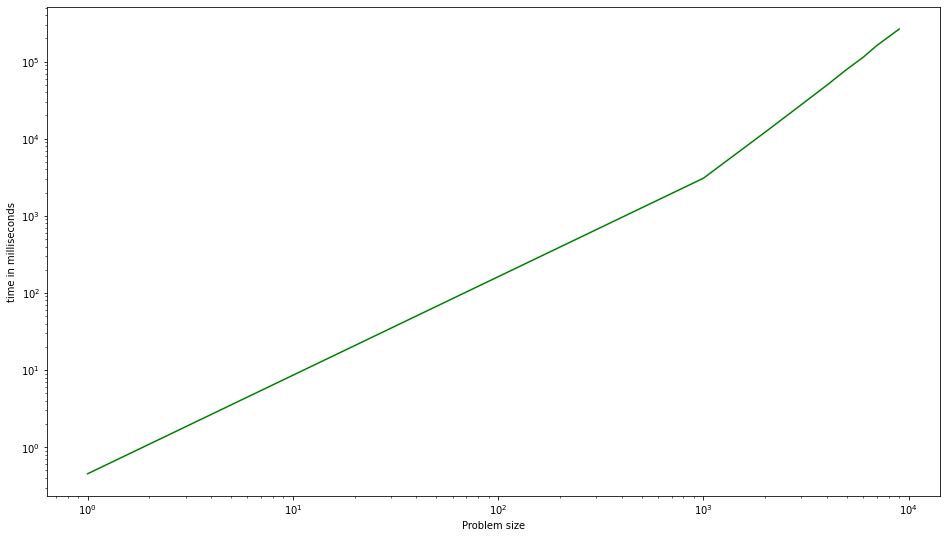

time = 0.336952 * n ^ 1.443


In [15]:
seq = read_fasta()
(A_name, A) = seq[0]
(B_name, B) = seq[1]
A = clean_data(A[:10000])
B = clean_data(B[:10000])
problems = [(i, (A[:i], B[:i])) for i in range(1, 10001, 1000)]
timeProblems(problems, matchSequencesDP, fit='polynomial')

Time equation: time = 0.336952 * n ^ 1.443


> Estimated time for problem size 30,000: 16 minutes

> Actual time for problem size 30,000: 23 minutes

The runtime grows with the square of the sequence length because as the sequence length n increases the size of our cache (n by n) increases to n^2


---
Compare 5 sequences

In [14]:
seq = read_fasta()
(A_name, A) = seq[0]
(B_name, B) = seq[1]
(C_name, C) = seq[2]
(D_name, D) = seq[3]
(E_name, E) = seq[4]

A = clean_data(A[:10000])
B = clean_data(B[:10000])
C = clean_data(C[:10000])
D = clean_data(D[:10000])
E = clean_data(E[:10000])

a_b = matchSequencesDP(A[:5000], B[:5000])
a_c = matchSequencesDP(A[:5000], C[:5000])
a_d = matchSequencesDP(A[:5000], D[:5000])
a_e = matchSequencesDP(A[:5000], E[:5000])
b_c = matchSequencesDP(B[:5000], C[:5000])
b_d = matchSequencesDP(B[:5000], D[:5000])
b_e = matchSequencesDP(B[:5000], E[:5000])
c_d = matchSequencesDP(C[:5000], D[:5000])
c_e = matchSequencesDP(C[:5000], E[:5000])
d_e = matchSequencesDP(D[:5000], E[:5000])

titles = ['A', 'B', 'C', 'D', 'E']
data = [['-', a_b, a_c, a_d, a_e],
        [a_b, '-', b_c, b_d, b_e],
        [a_c, b_c, '-', c_d, c_e],
        [a_d, b_d, c_d, '-', d_e],
        [a_e, b_e, c_e, d_e, '-']]
format_row = "{:>12}" * (len(titles) + 1)
print(format_row.format("", *titles))
for sequence, row in zip(titles, data):
  print(format_row.format(sequence, *row))

                       A           B           C           D           E
           A           -     24658.0     24619.0     24713.0     24963.0
           B     24658.0           -     24960.0     24928.0     24680.0
           C     24619.0     24960.0           -     24889.0     24641.0
           D     24713.0     24928.0     24889.0           -     24749.0
           E     24963.0     24680.0     24641.0     24749.0           -


---
Full Sequence alignment

In [21]:
seq = read_fasta()
(A_name, A) = seq[0]
(B_name, B) = seq[1]
A = clean_data(A)
B = clean_data(B)

matchSequencesDP(A,B)
f = open("full_sequence.txt", "x")
write_str = traceback_iterative(len(A), len(B))
n = len(write_str)
for i in range(n-1, 0, -1):
    f.write(write_str[i] + "\n")

f.close()